In [2]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [7]:
'''
Here we are gonna use Asymmetric depolarization channel (T1 ! = T2)
'''

'\nHere we are gonna use Asymmetric depolarization channel (T1 ! = T2)\n'

In [3]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])

In [5]:
qml.PauliZ.matrix==Z

tensor([[ True,  True],
        [ True,  True]], requires_grad=True)

In [3]:
'''
T1 = single-qubit (energy) relaxation time and 
T2 = dephasing time
'''

'\nT1 = single-qubit (energy) relaxation time and \nT2 = dephasing time\n'

In [6]:
t=np.linspace(1,200,200)*10**(-9)#60*10**(-9)
T1=400*10**(-9)
T2=200*10**(-9)
steps=4

In [8]:
# noise parameters p_x,p_y and p_z
def P(t,T1,T2):
    
    px=(1-np.exp(-t/T1))/4
    py=px
    pz=(1-np.exp(-t/T2))/2-px
    
    return px,py,pz

In [10]:
P(t[20],T1,T2)

(tensor(0.01278642, requires_grad=True),
 tensor(0.01278642, requires_grad=True),
 tensor(0.03705132, requires_grad=True))

In [11]:
dev=qml.device("default.mixed",wires=3)

In [12]:
@qml.qnode(dev)
def density_matrix(step):
   
    if step==1:
        qml.Hadamard(wires=0)
        return qml.state()
    
    if step==2:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        return qml.state()
    
    if step==3:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        return qml.state()
    
    
    if step==4:
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        qml.Hadamard(wires=0)
        return qml.state()

In [13]:
density_matrix(1)

tensor([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j]], requires_grad=False)

In [14]:
X1=np.kron(X,np.kron(I,I))
Y1=np.kron(Y,np.kron(I,I))
Z1=np.kron(Z,np.kron(I,I))

X2=np.kron(I,np.kron(X,I))
Y2=np.kron(I,np.kron(Y,I))
Z2=np.kron(I,np.kron(Z,I))

X3=np.kron(I,np.kron(I,X))
Y3=np.kron(I,np.kron(I,Y))
Z3=np.kron(I,np.kron(I,Z))

In [15]:
def Decoherent_state_1( t,  T1,  T2,  steps):
    
    #rho=ρ_noise
    rho=density_matrix(steps)
    
    px,py,pz=P(t,T1,T2)
    
    epsilon_ADC_1=(1-(px+py+pz))*rho + px*np.dot(X1,np.dot(rho,X1)) + py*np.dot(Y1,np.dot(rho,Y1)) + pz*np.dot(Z1,np.dot(rho,Z1))
    
    return epsilon_ADC_1
    

In [16]:
ρ_noise=[]
ρ_noise=[Decoherent_state_1(time,T1,T2,1) for time in t] 
len(ρ_noise)

200

In [17]:
# Function to find the fidelity between two density matrix
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return ((np.trace(np.dot(np.transpose(np.conj(rho1)),rho2))))  # as one of them is pure (entangled) state

In [27]:
rho2=density_matrix(1)  # this is the pure density matrix 
F=[]
for rho1 in ρ_noise:
    F.append(Fidelity(rho1,rho2))
    
len(F)

200

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


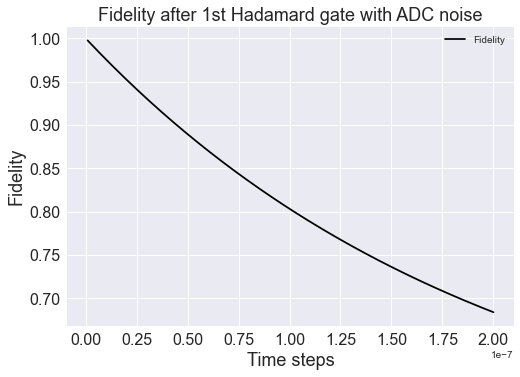

In [20]:
plt.style.use("seaborn")
plt.plot(t,F,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after 1st Hadamard gate with ADC noise", fontsize=18)
plt.legend()
plt.show()

In [21]:
cnot=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [22]:
def Decoherent_state_2( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(cnot,I),rho),np.kron(cnot,I)) # applying 1st CNOT to qubits=[0,1]
    
    px,py,pz=P(t,T1,T2)
    
    epsilon_ADC_1=(1-(px+py+pz))*rho + px*np.dot(X1,np.dot(rho,X1)) + py*np.dot(Y1,np.dot(rho,Y1))+ pz*np.dot(Z1,np.dot(rho,Z1))
    
    epsilon_ADC_2=(1-(px+py+pz))*epsilon_ADC_1+px*np.dot(X2,np.dot(epsilon_ADC_1,X2))+py*np.dot(Y2,np.dot(epsilon_ADC_1,Y2))+ \
                   pz*np.dot(Z2,np.dot(epsilon_ADC_1,Z2))
    
    epsilon_ADC_3=(1-(px+py+pz))*epsilon_ADC_2+px*np.dot(X3,np.dot(epsilon_ADC_2,X3))+py*np.dot(Y3,np.dot(epsilon_ADC_2,Y3))+ \
                   pz*np.dot(Z3,np.dot(epsilon_ADC_2,Z3))
    
    return epsilon_ADC_3
    

In [23]:
ρ_noise2=[]
ρ_noise2=[Decoherent_state_2(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise)] 
len(ρ_noise2)

200

In [24]:
rho2=density_matrix(2)  # this is the pure density matrix 
F2=[]
for rho1 in ρ_noise2:
    F2.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


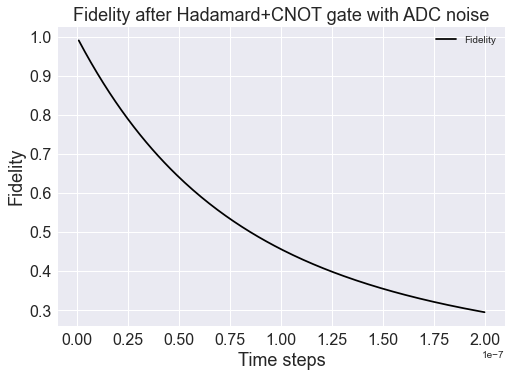

In [41]:
plt.style.use("seaborn")
plt.plot(t,F2,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT gate with ADC noise", fontsize=18)
plt.legend()
plt.show()

In [29]:
cnot_0_2=np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1],[0,0,0,0,0,0,1,0]])
cnot_0_2

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]], requires_grad=True)

In [30]:
def Decoherent_state_3( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(cnot_0_2,rho),cnot_0_2) # applying 1st CNOT to qubits=[0,1]

    px,py,pz=P(t,T1,T2)
    
    epsilon_ADC_1=(1-(px+py+pz))*rho + px*np.dot(X1,np.dot(rho,X1)) + py*np.dot(Y1,np.dot(rho,Y1))+ pz*np.dot(Z1,np.dot(rho,Z1))
    
    epsilon_ADC_2=(1-(px+py+pz))*epsilon_ADC_1+px*np.dot(X2,np.dot(epsilon_ADC_1,X2))+py*np.dot(Y2,np.dot(epsilon_ADC_1,Y2))+ \
                   pz*np.dot(Z2,np.dot(epsilon_ADC_1,Z2))
    
    epsilon_ADC_3=(1-(px+py+pz))*epsilon_ADC_2+px*np.dot(X3,np.dot(epsilon_ADC_2,X3))+py*np.dot(Y3,np.dot(epsilon_ADC_2,Y3))+ \
                   pz*np.dot(Z3,np.dot(epsilon_ADC_2,Z3))
    
    return epsilon_ADC_3

    

In [31]:
ρ_noise3=[]
ρ_noise3=[Decoherent_state_3(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise2)] 
len(ρ_noise3)

200

In [32]:
rho2=density_matrix(3)  # this is the pure density matrix 
F3=[]
for rho1 in ρ_noise3:
    F3.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


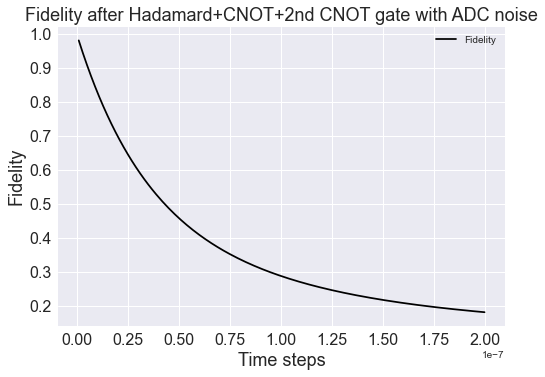

In [42]:
plt.style.use("seaborn")
plt.plot(t,F3,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT gate with ADC noise", fontsize=18)
plt.legend()
plt.show()

In [34]:
H=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

In [37]:
def Decoherent_state_4( t,  T1,  T2, density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(np.kron(H,I),I),rho),(np.kron(np.kron(H,I),I)))
    
    px,py,pz=P(t,T1,T2)
    
    epsilon_ADC_1=(1-(px+py+pz))*rho + px*np.dot(X1,np.dot(rho,X1)) + py*np.dot(Y1,np.dot(rho,Y1))+ pz*np.dot(Z1,np.dot(rho,Z1))
    
    epsilon_ADC_2=(1-(px+py+pz))*epsilon_ADC_1+px*np.dot(X2,np.dot(epsilon_ADC_1,X2))+py*np.dot(Y2,np.dot(epsilon_ADC_1,Y2))+ \
                   pz*np.dot(Z2,np.dot(epsilon_ADC_1,Z2))
    
    epsilon_ADC_3=(1-(px+py+pz))*epsilon_ADC_2+px*np.dot(X3,np.dot(epsilon_ADC_2,X3))+py*np.dot(Y3,np.dot(epsilon_ADC_2,Y3))+ \
                   pz*np.dot(Z3,np.dot(epsilon_ADC_2,Z3))
    
    return epsilon_ADC_3

In [38]:
ρ_noise4=[]
ρ_noise4=[Decoherent_state_4(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise3)] 
len(ρ_noise4)

200

In [39]:
rho2=density_matrix(4)  # this is the pure density matrix 
F4=[]
for rho1 in ρ_noise4:
    F4.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


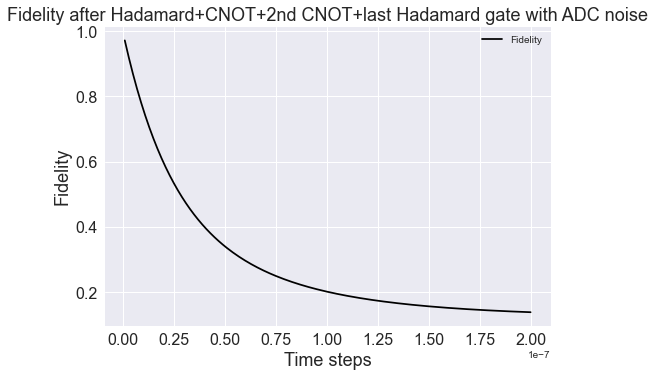

In [43]:
plt.style.use("seaborn")
plt.plot(t,F4,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT+last Hadamard gate with ADC noise", fontsize=18)
plt.legend()
plt.show()

In [44]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

In [45]:
for index,fidelity in enumerate(F4):
    if fidelity>0.545 and fidelity<0.555:
        print(index,"->",fidelity)

23 -> (0.5464218723725504+0j)


In [56]:
Fidelity(ρ_noise4[23],density_matrix(4))

(0.5464218723725504+0j)

In [57]:
rho_test=ρ_noise4[23]

In [61]:
density_matrix(4)

tensor([[ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.25+0.j,
          0.  +0.j,  0.  +0.j, -0.25+0.j],
        [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
          0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
          0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.25+0.j,
          0.  +0.j,  0.  +0.j, -0.25+0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.25+0.j,
          0.  +0.j,  0.  +0.j, -0.25+0.j],
        [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
          0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
          0.  +0.j,  0.  +0.j,  0.  +0.j],
        [-0.25+0.j,  0.  +0.j,  0.  +0.j, -0.25+0.j, -0.25+0.j,
          0.  +0.j,  0.  +0.j,  0.25+0.j]], requires_grad=False)

In [62]:
rho_test

tensor([[ 0.20713085+0.j,  0.        +0.j,  0.        +0.j,
          0.08752381+0.j,  0.16934039+0.j,  0.        +0.j,
          0.        +0.j, -0.08242682+0.j],
        [ 0.        +0.j,  0.04286915+0.j,  0.00262493+0.j,
          0.        +0.j,  0.        +0.j, -0.00507869+0.j,
         -0.00247206+0.j,  0.        +0.j],
        [ 0.        +0.j,  0.00262493+0.j,  0.04286915+0.j,
          0.        +0.j,  0.        +0.j,  0.00247206+0.j,
          0.00507869+0.j,  0.        +0.j],
        [ 0.08752381+0.j,  0.        +0.j,  0.        +0.j,
          0.20713085+0.j,  0.08242682+0.j,  0.        +0.j,
          0.        +0.j, -0.16934039+0.j],
        [ 0.16934039+0.j,  0.        +0.j,  0.        +0.j,
          0.08242682+0.j,  0.20713085+0.j,  0.        +0.j,
          0.        +0.j, -0.08752381+0.j],
        [ 0.        +0.j, -0.00507869+0.j,  0.00247206+0.j,
          0.        +0.j,  0.        +0.j,  0.04286915+0.j,
         -0.00262493+0.j,  0.        +0.j],
        [ 0.    

In [59]:
rho_1 = qi.partial_trace(rho_test,[1,2])

In [60]:
rho_1

DensityMatrix([[0.5+0.j, 0. +0.j],
               [0. +0.j, 0.5+0.j]],
              dims=(2,))
